In [26]:
import requests
import pandas as pd
from datetime import datetime
import os

In [14]:
# Define API parameters
url = 'https://api.coingecko.com/api/v3/coins/markets'
param = {
    'vs_currency': 'usd',
    'order': 'market_cap_desc',
    'per_page': 100,
    'page': 1,
}

In [43]:
# Fetch Data
response = requests.get(url, params=params)
if response.status_code == 200:
    print("Data retrieved successfully.")
    data = response.json()

    # Create DataFrame
    df = pd.DataFrame(data)
    df = df[['id', 'current_price', 'market_cap', 'price_change_percentage_24h', 'ath', 'atl']]

    # Add timestamp
    today = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    df['timestamp'] = today

    # Save data with timestamp
    if not os.path.exists("crypto_data"):
        os.makedirs("crypto_data")
    df.to_csv(f'crypto_data/daily_data_{today}.csv', index=False)
    print("Data saved successfully.")

else:
    print(f"Error retrieving data: {response.status_code}")


Data retrieved successfully.
Data saved successfully.


In [28]:
# Adding a 7-day moving average of the current price (example)
df['7_day_MA'] = df['current_price'].rolling(window=7).mean()

# Relative Strength Index (RSI) Calculation
def calculate_rsi(data, window=14):
    delta = data['current_price'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df)


In [29]:
# Set thresholds for alerts
ALERT_THRESHOLD = 10  # 10% change as an example

# Identify significant price changes
significant_changes = df[abs(df['price_change_percentage_24h']) >= ALERT_THRESHOLD]

# Print alerts
for _, row in significant_changes.iterrows():
    if row['price_change_percentage_24h'] > 0:
        print(f"🔼 {row['id']} has increased by {row['price_change_percentage_24h']}%")
    else:
        print(f"🔻 {row['id']} has decreased by {row['price_change_percentage_24h']}%")


🔼 pepe has increased by 57.62723%
🔼 dogwifcoin has increased by 32.36219%
🔼 bonk has increased by 15.65365%
🔼 floki has increased by 12.72754%
🔼 peanut-the-squirrel has increased by 40.03187%
🔼 popcat has increased by 25.21179%
🔼 based-brett has increased by 30.62562%
🔼 bitcoin-cash-sv has increased by 20.22965%
🔼 bittorrent has increased by 10.63987%
🔼 cat-in-a-dogs-world has increased by 20.6083%


In [30]:
# Placeholder for sentiment analysis (e.g., Twitter or News API)
def analyze_sentiment(crypto_id):
    # Placeholder function for sentiment analysis
    # In reality, you’d call an API and process sentiment from tweets or news articles
    # For now, let’s assume a random sentiment for demonstration purposes
    import random
    sentiment = random.choice(['Positive', 'Negative', 'Neutral'])
    return sentiment

df['sentiment'] = df['id'].apply(analyze_sentiment)
print(df[['id', 'sentiment']].head())


            id sentiment
0      bitcoin   Neutral
1     ethereum   Neutral
2       tether  Positive
3       solana  Negative
4  binancecoin  Positive


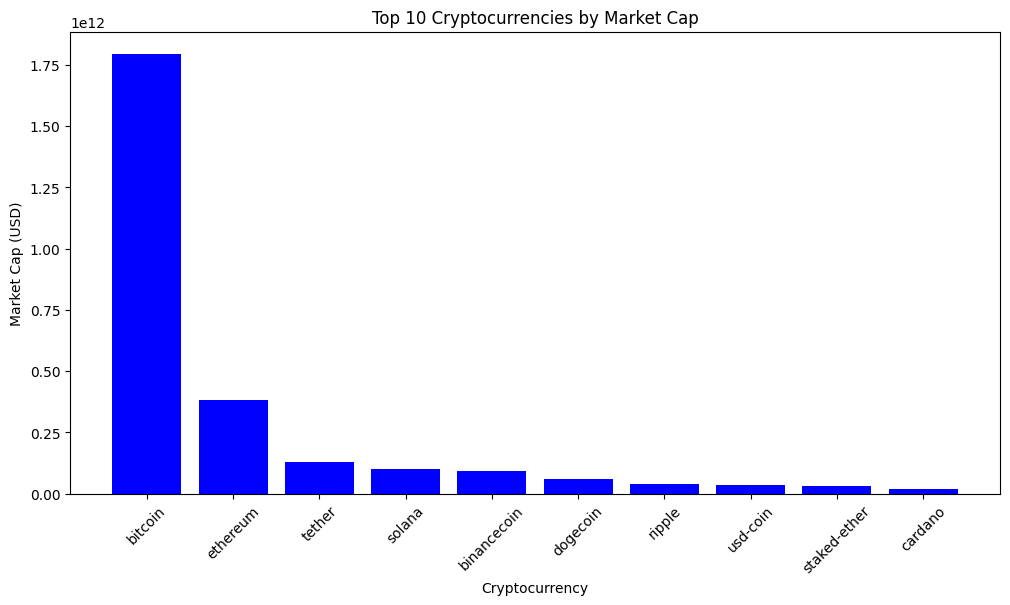

In [31]:
import matplotlib.pyplot as plt

# Top 10 cryptos by market cap
top_10 = df.nlargest(10, 'market_cap')

plt.figure(figsize=(12, 6))
plt.bar(top_10['id'], top_10['market_cap'], color='blue')
plt.xlabel("Cryptocurrency")
plt.ylabel("Market Cap (USD)")
plt.title("Top 10 Cryptocurrencies by Market Cap")
plt.xticks(rotation=45)
plt.show()


In [32]:
import sqlite3

# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect("crypto_data.db")
df.to_sql("crypto_data", conn, if_exists="append", index=False)
conn.close()
print("Data saved to database.")


Data saved to database.


In [33]:
from statsmodels.tsa.arima.model import ARIMA

# Example ARIMA model on historical data (assumes a historical dataset)
historical_prices = df['current_price'].values  # Example only
model = ARIMA(historical_prices, order=(5, 1, 0))  # Adjust order as needed
model_fit = model.fit()
forecast = model_fit.forecast(steps=7)  # 7-day forecast
print("7-day forecast:", forecast)


7-day forecast: [12409.71611358 13706.12039954 14820.52068977 39620.32561357
 19321.66896201 16062.50138494 18303.38636601]


In [42]:
# Example Sharpe Ratio calculation
risk_free_rate = 0.01  # Assuming a risk-free rate
returns = df['price_change_percentage_24h'] / 100
sharpe_ratio = (returns.mean() - risk_free_rate) / returns.std()
df['sharpe_ratio'] = sharpe_ratio
print("Sharpe Ratio:", sharpe_ratio)


Sharpe Ratio: 0.25441311165474706
